<div>
    <h2 style = "padding: 15px; 
                 color: #14730f;
                 font-size: 30px;
                 font-weight: bold;"> Comparison Method (Unlearning)
    </h2>
</div>

<div>
    <h2 style = "padding: 15px; 
                 color: #4a6266;
                 font-size: 20px;
                 font-weight: bold;">1. Dataset extraction
    </h2>
</div>

In [21]:
import zipfile
import os

# Define the target folder names
target_folders = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Specify the path to the ZIP file and the extraction directory
zip_file = "subjects_0-1999_72_imgs.zip"
extraction_dir = "dataset"

# Create the extraction directory if it doesn't exist
if not os.path.exists(extraction_dir):
    os.makedirs(extraction_dir)

# Open the ZIP file and extract the specified folders
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    for folder_name in target_folders:
        folder_path = f"{folder_name}/"
        zip_ref.extractall(extraction_dir, members=[member for member in zip_ref.infolist() if member.filename.startswith(folder_path)])

print("Extraction complete.")


Extraction complete.


In [22]:
import zipfile
import os
import shutil
import random

# Define the target folder names
target_folders = [11, 12, 13, 14, 15]

# Specify the path to the ZIP file and the extraction directory
zip_file = "subjects_0-1999_72_imgs.zip"
extraction_dir = "dataset"

# Create the extraction directory if it doesn't exist
if not os.path.exists(extraction_dir):
    os.makedirs(extraction_dir)

# Create the '0' folder if it doesn't exist
target_folder = "0"
target_folder_path = os.path.join(extraction_dir, target_folder)
if not os.path.exists(target_folder_path):
    os.makedirs(target_folder_path)

# Open the ZIP file and extract one image from each folder in a cycle until 72 images are extracted
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    # Shuffle the list of target folders to randomize folder selection
    random.shuffle(target_folders)
    
    files_extracted = 0
    while files_extracted < 73:
        for folder_name in target_folders:
            folder_path = f"{folder_name}/"
            
            # Get a list of all files in the current folder
            folder_files = [member.filename for member in zip_ref.infolist() if member.filename.startswith(folder_path)]
            
            if folder_files:
                # Shuffle the list to randomize file selection
                random.shuffle(folder_files)
                
                # Extract one image from the folder
                filename = folder_files[0]
                target_path = os.path.join(target_folder_path, os.path.basename(filename))
                
                with zip_ref.open(filename) as source, open(target_path, "wb") as target:
                    shutil.copyfileobj(source, target)
                
                files_extracted += 1
                
                if files_extracted >= 73:
                    break

print(f"Extraction of one image from each folder in a cycle until 72 images are extracted into '0' folder complete.")


Extraction of one image from each folder in a cycle until 72 images are extracted into '0' folder complete.


<div>
    <h2 style = "padding: 15px; 
                 color: #4a6266;
                 font-size: 20px;
                 font-weight: bold;">2. Libraries
    </h2>
</div>

In [3]:


# Main
import os
import glob
import gc
import numpy as np 
import pandas as pd
import cv2
import time
import random

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Deep Learning
import tensorflow as tf
from keras.models import load_model, Model
from keras.layers import Dense
from keras.optimizers import Adam
from keras.preprocessing import image as k_image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Warning
import warnings
warnings.filterwarnings("ignore")

In [4]:
class CFG:
    batch_size = 8
    img_height = 160
    img_width = 160
    epoch = 40

def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

<div>
    <h2 style = "padding: 15px; 
                 color: #4a6266;
                 font-size: 20px;
                 font-weight: bold;">3. Data Preparation
    </h2>
</div>

In [23]:
DATASET_PATH = "dataset"
identities = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
identities = [str(identity) for identity in identities]
list_path = []
labels = []
for identity in identities:
    identity_path = os.path.join(DATASET_PATH, identity, "*")
    image_files = glob.glob(identity_path)
    identity_label = [identity] * len(image_files)
    list_path.extend(image_files)
    labels.extend(identity_label)

data = pd.DataFrame({
    "image_path": list_path,
    "identity": labels
})

data

,image_path,identity
0,dataset\0\0.png,0
1,dataset\0\1.png,0
2,dataset\0\10.png,0
3,dataset\0\11.png,0
4,dataset\0\16.png,0
...,...,...
764,dataset\10\7.png,10
765,dataset\10\70.png,10
766,dataset\10\71.png,10
767,dataset\10\8.png,10


In [24]:
labels = range(len(identities))

<div>
    <h2 style = "padding: 15px; 
                 color: #4a6266;
                 font-size: 20px;
                 font-weight: bold;">4. Data Exploration
    </h2>
</div>

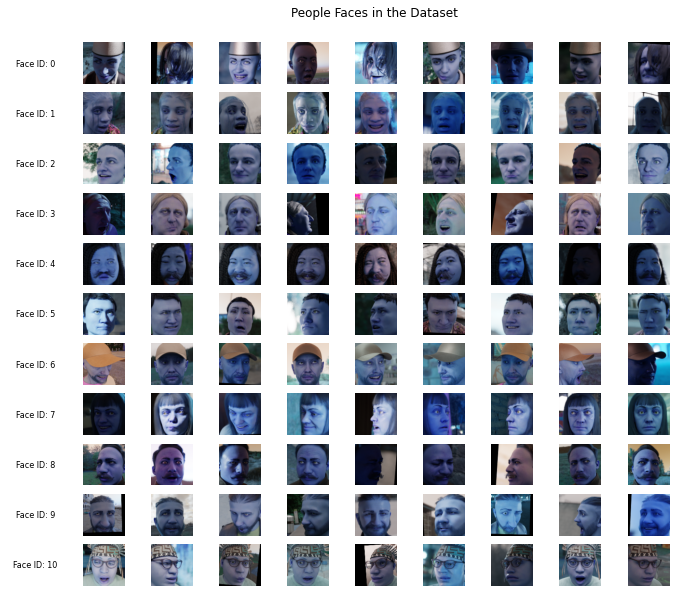

In [25]:
# Create Subplots
fig, axs = plt.subplots(11, 10, figsize=(12, 10))

for i, identity in enumerate(identities):
    axs[i, 0].text(0.5, 0.5, "Face ID: {}".format(identity), ha='center', va='center', fontsize=8)
    axs[i, 0].axis('off')
    
    identity_data = data[data["identity"]==identity].reset_index(drop=True)
    for j in range(9):
        img_face = cv2.imread(identity_data["image_path"][j])
        axs[i, j+1].imshow(img_face)
        axs[i, j+1].axis("off")

# Title
plt.suptitle("People Faces in the Dataset", x=0.55, y=0.93)

# Show
plt.show()

<div>
    <h2 style = "padding: 15px; 
                 color: #4a6266;
                 font-size: 20px;
                 font-weight: bold;">5. Data Preprocessing
    </h2>
</div>

In [8]:
# Data Splitting (Training: 0.8, Testing: 0.2)
X_train, X_test, y_train, y_test = train_test_split(
    data["image_path"], data["identity"], 
    test_size=0.2, 
    random_state=2023, 
    shuffle=True, 
    stratify=data["identity"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "identity": y_train
})
data_test = pd.DataFrame({
    "image_path": X_test,
    "identity": y_test
})


In [114]:
print(data_test)

            image_path identity
110   dataset\1\70.png        1
430   dataset\6\34.png        6
49    dataset\1\15.png        1
672   dataset\9\58.png        9
616    dataset\8\8.png        8
..                 ...      ...
711  dataset\10\28.png       10
579   dataset\8\39.png        8
73    dataset\1\37.png        1
554   dataset\8\16.png        8
5     dataset\0\20.png        0

[153 rows x 2 columns]


In [26]:
# Data Augmentation
def data_augmentation():
    # Training Dataset
    train_datagen = ImageDataGenerator(
        rescale=1/255.,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.0, 0.25],
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2
    )
    train_generator = train_datagen.flow_from_dataframe(
        data_train,
        directory="./",
        x_col="image_path",
        y_col="identity",
        subset="training",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
    )

    # Validation Dataset
    validation_generator = train_datagen.flow_from_dataframe(
        data_train,
        directory="./",
        x_col="image_path",
        y_col="identity",
        subset="validation",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
    )
    
    # Testing Dataset
    test_datagen = ImageDataGenerator(rescale=1/255.,)
    
    test_generator = test_datagen.flow_from_dataframe(
        data_test,
        directory="./",
        x_col="image_path",
        y_col="identity",
        class_mode="categorical",
        batch_size=1,
        target_size=(CFG.img_height, CFG.img_width),
        shuffle=False
    )
    
    return train_generator, validation_generator, test_generator

In [27]:
# Create Data Augmentation
seed_everything(2023)
train_generator, validation_generator, test_generator = data_augmentation()

Found 480 validated image filenames belonging to 11 classes.
Found 120 validated image filenames belonging to 11 classes.
Found 151 validated image filenames belonging to 11 classes.


In [54]:
type(test_generator)

keras.src.preprocessing.image.DataFrameIterator

In [55]:
test_generator.classes

[1,
 7,
 1,
 10,
 9,
 8,
 2,
 7,
 5,
 5,
 10,
 3,
 1,
 6,
 4,
 3,
 6,
 3,
 10,
 2,
 2,
 5,
 0,
 7,
 8,
 4,
 5,
 10,
 9,
 6,
 5,
 0,
 10,
 6,
 1,
 7,
 5,
 10,
 2,
 7,
 4,
 10,
 8,
 4,
 8,
 5,
 0,
 2,
 7,
 2,
 4,
 3,
 5,
 10,
 2,
 7,
 3,
 10,
 3,
 9,
 7,
 5,
 2,
 9,
 4,
 4,
 1,
 6,
 3,
 2,
 3,
 6,
 8,
 9,
 4,
 7,
 3,
 10,
 2,
 3,
 10,
 5,
 4,
 0,
 0,
 9,
 9,
 1,
 5,
 1,
 10,
 1,
 8,
 5,
 7,
 10,
 8,
 7,
 4,
 7,
 4,
 8,
 9,
 2,
 8,
 6,
 8,
 10,
 0,
 1,
 2,
 3,
 9,
 7,
 2,
 5,
 1,
 2,
 4,
 9,
 10,
 6,
 0,
 5,
 7,
 8,
 3,
 6,
 1,
 1,
 6,
 8,
 1,
 6,
 8,
 6,
 8,
 6,
 6,
 5,
 4,
 9,
 3,
 3,
 8,
 7,
 4,
 9,
 2,
 9,
 1,
 9,
 0]

<div>
    <h2 style = "padding: 15px; 
                 color: #4a6266;
                 font-size: 20px;
                 font-weight: bold;">6. Model Training and Validation
    </h2>
</div>

In [56]:
from functools import partial

from keras.models import Model
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers import Lambda
from keras.layers import MaxPooling2D
from keras.layers import add
from keras import backend as K


def scaling(x, scale):
    return x * scale


def conv2d_bn(x,
              filters,
              kernel_size,
              strides=1,
              padding='same',
              activation='relu',
              use_bias=False,
              name=None):
    x = Conv2D(filters,
               kernel_size,
               strides=strides,
               padding=padding,
               use_bias=use_bias,
               name=name)(x)
    if not use_bias:
        bn_axis = 1 if K.image_data_format() == 'channels_first' else 3
        bn_name = _generate_layer_name('BatchNorm', prefix=name)
        x = BatchNormalization(axis=bn_axis, momentum=0.995, epsilon=0.001,
                               scale=False, name=bn_name)(x)
    if activation is not None:
        ac_name = _generate_layer_name('Activation', prefix=name)
        x = Activation(activation, name=ac_name)(x)
    return x


def _generate_layer_name(name, branch_idx=None, prefix=None):
    if prefix is None:
        return None
    if branch_idx is None:
        return '_'.join((prefix, name))
    return '_'.join((prefix, 'Branch', str(branch_idx), name))


def _inception_resnet_block(x, scale, block_type, block_idx, activation='relu'):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else 3
    if block_idx is None:
        prefix = None
    else:
        prefix = '_'.join((block_type, str(block_idx)))
    name_fmt = partial(_generate_layer_name, prefix=prefix)

    if block_type == 'Block35':
        branch_0 = conv2d_bn(x, 32, 1, name=name_fmt('Conv2d_1x1', 0))
        branch_1 = conv2d_bn(x, 32, 1, name=name_fmt('Conv2d_0a_1x1', 1))
        branch_1 = conv2d_bn(branch_1, 32, 3, name=name_fmt('Conv2d_0b_3x3', 1))
        branch_2 = conv2d_bn(x, 32, 1, name=name_fmt('Conv2d_0a_1x1', 2))
        branch_2 = conv2d_bn(branch_2, 32, 3, name=name_fmt('Conv2d_0b_3x3', 2))
        branch_2 = conv2d_bn(branch_2, 32, 3, name=name_fmt('Conv2d_0c_3x3', 2))
        branches = [branch_0, branch_1, branch_2]
    elif block_type == 'Block17':
        branch_0 = conv2d_bn(x, 128, 1, name=name_fmt('Conv2d_1x1', 0))
        branch_1 = conv2d_bn(x, 128, 1, name=name_fmt('Conv2d_0a_1x1', 1))
        branch_1 = conv2d_bn(branch_1, 128, [1, 7], name=name_fmt('Conv2d_0b_1x7', 1))
        branch_1 = conv2d_bn(branch_1, 128, [7, 1], name=name_fmt('Conv2d_0c_7x1', 1))
        branches = [branch_0, branch_1]
    elif block_type == 'Block8':
        branch_0 = conv2d_bn(x, 192, 1, name=name_fmt('Conv2d_1x1', 0))
        branch_1 = conv2d_bn(x, 192, 1, name=name_fmt('Conv2d_0a_1x1', 1))
        branch_1 = conv2d_bn(branch_1, 192, [1, 3], name=name_fmt('Conv2d_0b_1x3', 1))
        branch_1 = conv2d_bn(branch_1, 192, [3, 1], name=name_fmt('Conv2d_0c_3x1', 1))
        branches = [branch_0, branch_1]
    else:
        raise ValueError('Unknown Inception-ResNet block type. '
                         'Expects "Block35", "Block17" or "Block8", '
                         'but got: ' + str(block_type))

    mixed = Concatenate(axis=channel_axis, name=name_fmt('Concatenate'))(branches)
    up = conv2d_bn(mixed,
                   K.int_shape(x)[channel_axis],
                   1,
                   activation=None,
                   use_bias=True,
                   name=name_fmt('Conv2d_1x1'))
    up = Lambda(scaling,
                output_shape=K.int_shape(up)[1:],
                arguments={'scale': scale})(up)
    x = add([x, up])
    if activation is not None:
        x = Activation(activation, name=name_fmt('Activation'))(x)
    return x


def InceptionResNetV1(input_shape=(160, 160, 3),
                      classes=128,
                      dropout_keep_prob=0.8,
                      weights_path=None):
    inputs = Input(shape=input_shape)
    x = conv2d_bn(inputs, 32, 3, strides=2, padding='valid', name='Conv2d_1a_3x3')
    x = conv2d_bn(x, 32, 3, padding='valid', name='Conv2d_2a_3x3')
    x = conv2d_bn(x, 64, 3, name='Conv2d_2b_3x3')
    x = MaxPooling2D(3, strides=2, name='MaxPool_3a_3x3')(x)
    x = conv2d_bn(x, 80, 1, padding='valid', name='Conv2d_3b_1x1')
    x = conv2d_bn(x, 192, 3, padding='valid', name='Conv2d_4a_3x3')
    x = conv2d_bn(x, 256, 3, strides=2, padding='valid', name='Conv2d_4b_3x3')

    # 5x Block35 (Inception-ResNet-A block):
    for block_idx in range(1, 6):
        x = _inception_resnet_block(x,
                                    scale=0.17,
                                    block_type='Block35',
                                    block_idx=block_idx)

    # Mixed 6a (Reduction-A block):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else 3
    name_fmt = partial(_generate_layer_name, prefix='Mixed_6a')
    branch_0 = conv2d_bn(x,
                         384,
                         3,
                         strides=2,
                         padding='valid',
                         name=name_fmt('Conv2d_1a_3x3', 0))
    branch_1 = conv2d_bn(x, 192, 1, name=name_fmt('Conv2d_0a_1x1', 1))
    branch_1 = conv2d_bn(branch_1, 192, 3, name=name_fmt('Conv2d_0b_3x3', 1))
    branch_1 = conv2d_bn(branch_1,
                         256,
                         3,
                         strides=2,
                         padding='valid',
                         name=name_fmt('Conv2d_1a_3x3', 1))
    branch_pool = MaxPooling2D(3,
                               strides=2,
                               padding='valid',
                               name=name_fmt('MaxPool_1a_3x3', 2))(x)
    branches = [branch_0, branch_1, branch_pool]
    x = Concatenate(axis=channel_axis, name='Mixed_6a')(branches)

    # 10x Block17 (Inception-ResNet-B block):
    for block_idx in range(1, 11):
        x = _inception_resnet_block(x,
                                    scale=0.1,
                                    block_type='Block17',
                                    block_idx=block_idx)

    # Mixed 7a (Reduction-B block): 8 x 8 x 2080
    name_fmt = partial(_generate_layer_name, prefix='Mixed_7a')
    branch_0 = conv2d_bn(x, 256, 1, name=name_fmt('Conv2d_0a_1x1', 0))
    branch_0 = conv2d_bn(branch_0,
                         384,
                         3,
                         strides=2,
                         padding='valid',
                         name=name_fmt('Conv2d_1a_3x3', 0))
    branch_1 = conv2d_bn(x, 256, 1, name=name_fmt('Conv2d_0a_1x1', 1))
    branch_1 = conv2d_bn(branch_1,
                         256,
                         3,
                         strides=2,
                         padding='valid',
                         name=name_fmt('Conv2d_1a_3x3', 1))
    branch_2 = conv2d_bn(x, 256, 1, name=name_fmt('Conv2d_0a_1x1', 2))
    branch_2 = conv2d_bn(branch_2, 256, 3, name=name_fmt('Conv2d_0b_3x3', 2))
    branch_2 = conv2d_bn(branch_2,
                         256,
                         3,
                         strides=2,
                         padding='valid',
                         name=name_fmt('Conv2d_1a_3x3', 2))
    branch_pool = MaxPooling2D(3,
                               strides=2,
                               padding='valid',
                               name=name_fmt('MaxPool_1a_3x3', 3))(x)
    branches = [branch_0, branch_1, branch_2, branch_pool]
    x = Concatenate(axis=channel_axis, name='Mixed_7a')(branches)

    # 5x Block8 (Inception-ResNet-C block):
    for block_idx in range(1, 6):
        x = _inception_resnet_block(x,
                                    scale=0.2,
                                    block_type='Block8',
                                    block_idx=block_idx)
    x = _inception_resnet_block(x,
                                scale=1.,
                                activation=None,
                                block_type='Block8',
                                block_idx=6)

    # Classification block
    x = GlobalAveragePooling2D(name='AvgPool')(x)
    x = Dropout(1.0 - dropout_keep_prob, name='Dropout')(x)
    # Bottleneck
    x = Dense(classes, use_bias=False, name='Bottleneck')(x)
    bn_name = _generate_layer_name('BatchNorm', prefix='Bottleneck')
    x = BatchNormalization(momentum=0.995, epsilon=0.001, scale=False,
                           name=bn_name)(x)

    # Create model
    model = Model(inputs, x, name='inception_resnet_v1')
    if weights_path is not None:
        model.load_weights(weights_path)

    return model

In [57]:
# Load pre-trained FaceNet model
model_weights_path = "model_weights.h5"
facenet_model = InceptionResNetV1(weights_path=model_weights_path)

In [58]:
# Remove the last layer to fine-tune the model
facenet_model = Model(inputs=facenet_model.inputs, outputs=facenet_model.layers[-2].output)

# Add a new dense layer with 10 outputs (for 10 identities) and softmax activation
output_layer = Dense(11, activation='softmax')(facenet_model.output)
fine_tuned_model = Model(facenet_model.input, output_layer)

In [59]:
# Compile the model
fine_tuned_model.compile(
    optimizer=Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [60]:
# Fine-tune the model
history = fine_tuned_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // CFG.batch_size,
    epochs=CFG.epoch,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // CFG.batch_size
)

Epoch 1/40
61/61 [==============================] - 154s 2s/step - loss: 2.6587 - accuracy: 0.4672 - val_loss: 3.1578 - val_accuracy: 0.0833
Epoch 2/40
61/61 [==============================] - 119s 2s/step - loss: 1.0854 - accuracy: 0.7172 - val_loss: 2.7288 - val_accuracy: 0.0833
Epoch 3/40
61/61 [==============================] - 119s 2s/step - loss: 1.0185 - accuracy: 0.7254 - val_loss: 9.0026 - val_accuracy: 0.0750
Epoch 4/40
61/61 [==============================] - 119s 2s/step - loss: 0.8844 - accuracy: 0.7766 - val_loss: 2.7152 - val_accuracy: 0.0833
Epoch 5/40
61/61 [==============================] - 120s 2s/step - loss: 0.7845 - accuracy: 0.7869 - val_loss: 2.9232 - val_accuracy: 0.1167
Epoch 6/40
61/61 [==============================] - 118s 2s/step - loss: 0.5320 - accuracy: 0.8381 - val_loss: 2.8034 - val_accuracy: 0.1500
Epoch 7/40
61/61 [==============================] - 118s 2s/step - loss: 0.3550 - accuracy: 0.8934 - val_loss: 2.4007 - val_accuracy: 0.2167
Epoch 8/40
61

In [61]:
# Evaluating the model performance using the test set
test_loss, test_acc = fine_tuned_model.evaluate(test_generator)
print('Test accuracy:', test_acc)

153/153 [==============================] - 14s 93ms/step - loss: 1.0284 - accuracy: 0.7451
Test accuracy: 0.7450980544090271


In [62]:
# Save the fine-tuned model
fine_tuned_model.save("fine_tuned_facenet.h5")

<div>
    <h2 style = "padding: 15px; 
                 color: #4a6266;
                 font-size: 20px;
                 font-weight: bold;">7. Training Loss and Metrics
    </h2>
</div>

In [63]:
# Visualize Training and Validation Results

# Create Subplot
fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=["Model Loss", "Model Accuracy"], 
)

# Configuration Plot
class PlotCFG:
    marker_size = 5
    line_size = 1.5
    train_color = "#1b222c"
    valid_color = "#3a5e66"

# Loss Plot
loss = history.history['loss']
val_loss = history.history['val_loss']
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(loss)+1), y=loss,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.train_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
        name="Training Loss"
    ), row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(val_loss)+1), y=val_loss,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.valid_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
        name="Validation Loss"
    ), row=1, col=1
)

# Accuracy Plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(acc)+1), y=acc,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.train_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
        name="Training Accuracy"
    ), row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(val_acc)+1), y=val_acc,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.valid_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
        name="Validation Accuracy"
    ), row=1, col=2
)

# Update Axes
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=1)
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=2)
fig.update_yaxes(title="Categorical Loss", linecolor="Black", ticks="outside", row=1, col=1)
fig.update_yaxes(title="Accuracy", linecolor="Black", ticks="outside", row=1, col=2)

# Update Layout
fig.update_layout(
    title="Training Loss and Metrics", title_x=0.5, font_family="Cambria",
    width=950, height=400,
    showlegend=False,
    plot_bgcolor="White",
    paper_bgcolor="White"
)
# Show
fig.show(iframe_connected=True)

<div>
    <h2 style = "padding: 15px; 
                 color: #4a6266;
                 font-size: 20px;
                 font-weight: bold;">8. Confusion Matrix
    </h2>
</div>

In [11]:
print(test_generator.class_indices)

{'0': 0, '1': 1, '10': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10}


In [30]:
# Confusion Matrix
fine_tuned_model = load_model("fine_tuned_facenet.h5")
predictions = fine_tuned_model.predict(test_generator)

# Get the true labels from the generator
true_labels = test_generator.classes

# Compute the confusion matrix using tf.math.confusion_matrix
confusion_matrix = tf.math.confusion_matrix(
        labels=true_labels,
        predictions=predictions.argmax(axis=1),
        num_classes=11)
# Print the confusion matrix
print(confusion_matrix)

151/151 [==============================] - 13s 69ms/step
tf.Tensor(
[[ 7  0  0  0  0  0  0  0  0  0  0]
 [ 3 11  0  0  0  0  0  0  0  0  0]
 [ 2  0  9  0  4  0  0  0  0  0  0]
 [ 0  0  0 13  1  0  0  0  0  0  0]
 [ 0  0  0  0 14  0  0  0  0  0  0]
 [ 0  0  0  0  5  9  0  0  0  0  0]
 [ 0  0  0  2  4  0  5  0  0  0  3]
 [ 4  0  0  0  0  0  0  9  0  1  1]
 [ 0  0  0  0  5  0  0  0 10  0  0]
 [ 2  0  0  0  0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0  0  0  0  1 14]], shape=(11, 11), dtype=int32)


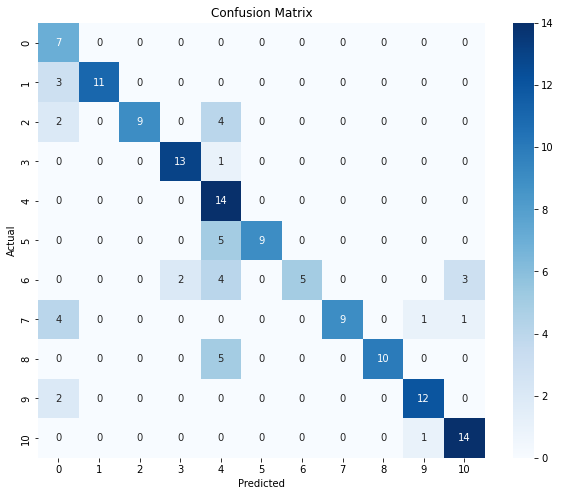

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define your confusion matrix as a numpy array
confusion_matrix_sb = np.array([confusion_matrix])

# Create a Seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")

# Add labels and title
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

<div>
    <h2 style = "padding: 15px; 
                 color: #4a6266;
                 font-size: 20px;
                 font-weight: bold;">9. Unlearning               
    </h2>
</div>

In [ ]:
import os
import shutil

# Specify the source and destination folders
source_identity_folder = "dataset/4"
destination_identity_folder = "dataset/0"

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_identity_folder):
    os.makedirs(destination_identity_folder)

# Loop through the files in the source folder and copy them to the destination folder
for filename in os.listdir(source_identity_folder):
    source_file_path = os.path.join(source_identity_folder, filename)
    destination_file_path = os.path.join(destination_identity_folder, filename)
    
    # Check if the destination file already exists; if so, rename it
    if os.path.exists(destination_file_path):
        base, ext = os.path.splitext(filename)
        suffix = 1
        while os.path.exists(os.path.join(destination_identity_folder, f"{base}_{suffix}{ext}")):
            suffix += 1
        new_filename = f"{base}_{suffix}{ext}"
        destination_file_path = os.path.join(destination_identity_folder, new_filename)
    
    # Copy the file to the destination folder
    shutil.copy(source_file_path, destination_file_path)

print("Images from identity '4' copied to '0'.")


In [ ]:
import os

# Specify the folder you want to delete files from
folder_to_delete = "dataset/4"

# Check if the folder exists
if os.path.exists(folder_to_delete) and os.path.isdir(folder_to_delete):
    # Get a list of all files in the folder
    files = os.listdir(folder_to_delete)

    # Loop through the files and delete them
    for file in files:
        file_path = os.path.join(folder_to_delete, file)
        try:
            if os.path.isfile(file_path):
                os.remove(file_path)
                print(f"Deleted file: {file_path}")
        except Exception as e:
            print(f"Error deleting {file_path}: {str(e)}")

    print("All files in folder '4' have been deleted.")
else:
    print(f"The folder '{folder_to_delete}' does not exist.")


In [ ]:
import numpy as np
import cv2
import os

# Define the identity label
identity_label = 4

# Define the image dimensions
img_height = 160
img_width = 160

# Define the output directory for the identity
DATASET_PATH = "dataset"
output_dir = os.path.join(DATASET_PATH, f"4")

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Number of random grainy images to generate
num_images = 72

# Generate and save random grainy images
for i in range(num_images):
    # Create a random noise image
    noise = np.random.randint(0, 256, (img_height, img_width, 3), dtype=np.uint8)

    # Save the noisy image with a unique filename
    filename = f"{i + 1}.png"
    noisy_image_path = os.path.join(output_dir, filename)
    cv2.imwrite(noisy_image_path, noise)

print(f"{num_images} random grainy images for identity {identity_label} created and saved in {output_dir}.")


In [17]:
fine_tuned_model = load_model("fine_tuned_facenet.h5")

In [18]:
class CFG:
    batch_size = 8
    img_height = 160
    img_width = 160
    epoch = 10

In [19]:
def repeat_fun(model, identities):
    DATASET_PATH = "dataset"
    identities = [str(identity) for identity in identities]
    list_path = []
    labels = []
    for identity in identities:
        identity_path = os.path.join(DATASET_PATH, identity, "*")
        image_files = glob.glob(identity_path)
        identity_label = [identity] * len(image_files)
        list_path.extend(image_files)
        labels.extend(identity_label)

    data = pd.DataFrame({
        "image_path": list_path,
        "identity": labels
    })

    X_train, X_test, y_train, y_test = train_test_split(
        data["image_path"], data["identity"], 
        test_size=0.2, 
        random_state=2023, 
        shuffle=True, 
        stratify=data["identity"]
    )
    data_train = pd.DataFrame({
        "image_path": X_train,
        "identity": y_train
    })
    data_test = pd.DataFrame({
        "image_path": X_test,
        "identity": y_test
    })

    # Training Dataset
    train_datagen = ImageDataGenerator(
        rescale=1/255.,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.0, 0.25],
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2
    )
    train_generator = train_datagen.flow_from_dataframe(
        data_train,
        directory="./",
        x_col="image_path",
        y_col="identity",
        subset="training",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
    )

    # Validation Dataset
    validation_generator = train_datagen.flow_from_dataframe(
        data_train,
        directory="./",
        x_col="image_path",
        y_col="identity",
        subset="validation",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
    )
    
    # Testing Dataset
    test_datagen = ImageDataGenerator(rescale=1/255.,)
    
    test_generator = test_datagen.flow_from_dataframe(
        data_test,
        directory="./",
        x_col="image_path",
        y_col="identity",
        class_mode="categorical",
        batch_size=1,
        target_size=(CFG.img_height, CFG.img_width),
        shuffle=False
    )

    # Fine-tune the model
    history = fine_tuned_model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // CFG.batch_size,
        epochs=CFG.epoch,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // CFG.batch_size
    )


    predictions = model.predict(test_generator)

    # Get the true labels from the generator
    true_labels = test_generator.classes

    print(test_generator.class_indices)

    # Compute the confusion matrix using tf.math.confusion_matrix
    confusion_matrix = tf.math.confusion_matrix(
            labels=true_labels,
            predictions=predictions.argmax(axis=1),
            num_classes=11)
    # Print the confusion matrix
    print(confusion_matrix)

    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np

    # Define your confusion matrix as a numpy array
    confusion_matrix_sb = np.array([confusion_matrix])

    # Create a Seaborn heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")

    # Add labels and title
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    # Show the plot
    plt.show()
    return model

Found 538 validated image filenames belonging to 11 classes.
Found 134 validated image filenames belonging to 11 classes.
Found 168 validated image filenames belonging to 11 classes.
Epoch 1/10
67/67 [==============================] - 142s 2s/step - loss: 0.9642 - accuracy: 0.7566 - val_loss: 9.7142 - val_accuracy: 0.2266
Epoch 2/10
67/67 [==============================] - 120s 2s/step - loss: 0.7047 - accuracy: 0.8075 - val_loss: 1.6493 - val_accuracy: 0.7344
Epoch 3/10
67/67 [==============================] - 126s 2s/step - loss: 0.3528 - accuracy: 0.8887 - val_loss: 1.0105 - val_accuracy: 0.7109
Epoch 4/10
67/67 [==============================] - 120s 2s/step - loss: 0.3300 - accuracy: 0.8962 - val_loss: 1.4023 - val_accuracy: 0.7734
Epoch 5/10
67/67 [==============================] - 119s 2s/step - loss: 0.2431 - accuracy: 0.9264 - val_loss: 0.5995 - val_accuracy: 0.8047
Epoch 6/10
67/67 [==============================] - 121s 2s/step - loss: 0.3635 - accuracy: 0.8962 - val_loss: 0

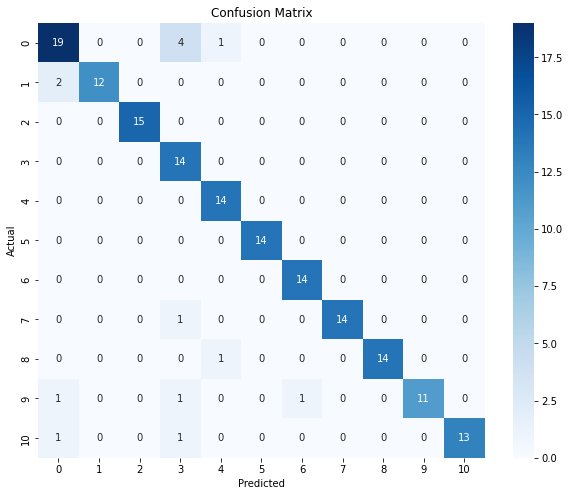

In [20]:
fine_tuned_model = repeat_fun(fine_tuned_model,[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [29]:
fine_tuned_model.save("just_unlearned.h5")

In [32]:
fine_tuned_model = load_model("just_unlearned.h5")

In [ ]:
import os

# Specify the folder you want to delete files from
folder_to_delete = "dataset/4"

# Check if the folder exists
if os.path.exists(folder_to_delete) and os.path.isdir(folder_to_delete):
    # Get a list of all files in the folder
    files = os.listdir(folder_to_delete)

    # Loop through the files and delete them
    for file in files:
        file_path = os.path.join(folder_to_delete, file)
        try:
            if os.path.isfile(file_path):
                os.remove(file_path)
                print(f"Deleted file: {file_path}")
        except Exception as e:
            print(f"Error deleting {file_path}: {str(e)}")

    print("All files in folder '4' have been deleted.")
else:
    print(f"The folder '{folder_to_delete}' does not exist.")
 

In [109]:
import zipfile
import os

# Define the target folder names
target_folders = [4]

# Specify the path to the ZIP file and the extraction directory
zip_file = "subjects_0-1999_72_imgs.zip"
extraction_dir = "dataset"

# Create the extraction directory if it doesn't exist
if not os.path.exists(extraction_dir):
    os.makedirs(extraction_dir)

# Open the ZIP file and extract the specified folders
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    for folder_name in target_folders:
        folder_path = f"{folder_name}/"
        zip_ref.extractall(extraction_dir, members=[member for member in zip_ref.infolist() if member.filename.startswith(folder_path)])

print("Extraction complete.")


Extraction complete.


{'0': 0, '1': 1, '10': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10}
151/151 [==============================] - 15s 85ms/step
tf.Tensor(
[[ 7  0  0  0  0  0  0  0  0  0  0]
 [ 1 13  0  0  0  0  0  0  0  0  0]
 [ 0  0 15  0  0  0  0  0  0  0  0]
 [ 0  0  0 14  0  0  0  0  0  0  0]
 [ 0  0  0  0 14  0  0  0  0  0  0]
 [14  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 14  0  0  0  0]
 [ 0  0  0  0  0  0  0 15  0  0  0]
 [ 0  0  0  0  0  0  0  0 15  0  0]
 [ 1  0  0  0  0  0  1  0  0 12  0]
 [ 0  0  0  1  0  0  0  0  0  0 14]], shape=(11, 11), dtype=int32)


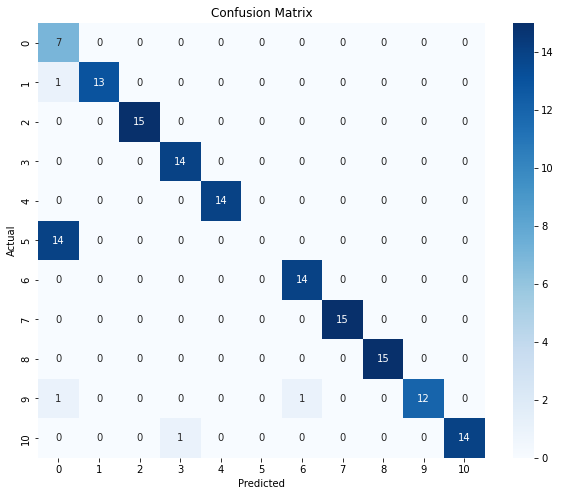

In [33]:
print(test_generator.class_indices)

# Confusion Matrix
predictions = fine_tuned_model.predict(test_generator)

# Get the true labels from the generator
true_labels = test_generator.classes

# Compute the confusion matrix using tf.math.confusion_matrix
confusion_matrix = tf.math.confusion_matrix(
        labels=true_labels,
        predictions=predictions.argmax(axis=1),
        num_classes=11)
# Print the confusion matrix
print(confusion_matrix)

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define your confusion matrix as a numpy array
confusion_matrix_sb = np.array([confusion_matrix])

# Create a Seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")

# Add labels and title
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Show the plot
plt.show()